In [1]:
from Decoder import Decoder
from Encoder import Encoder
from VectorQuantizer import VectorQuantizer
from Residual import Residual 
from VQModel import VQModel

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

import os

from six.moves import xrange
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
])

# Load your custom dataset
training_data = datasets.ImageFolder(root="data/images", transform=transform)
validation_data = datasets.ImageFolder(root="data/validation_images", transform=transform)

# Check the dataset size
print(f"Number of training samples: {len(training_data)}")

Number of training samples: 10000


In [16]:
batch_size = 10
num_training_updates = 2000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25
decay = 0.99
learning_rate = 1e-3

training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)

validation_loader = DataLoader(validation_data,
                               batch_size=1,
                               shuffle=True,
                               pin_memory=True)

In [4]:
model = VQModel(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [ ]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in xrange(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / 0.04
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        torch.save(model.state_dict(), f"Models/Model_{i+1}")
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

In [ ]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [18]:
(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

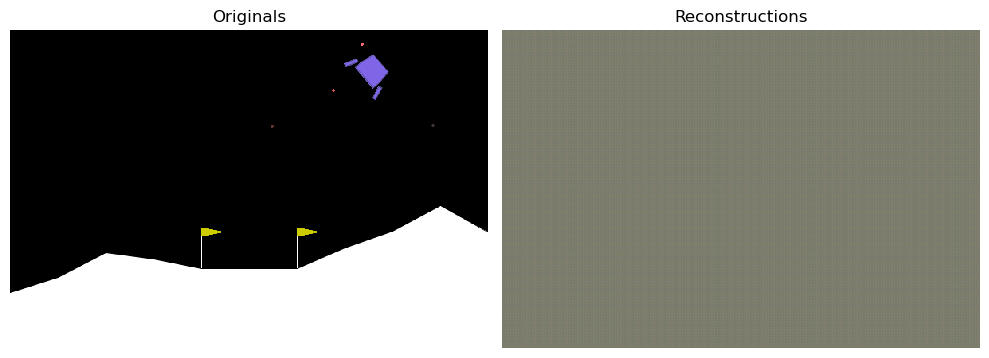

In [23]:
# Convert tensors to numpy arrays
npimg1 = (make_grid(valid_reconstructions.cpu().data) + 0.5).numpy()
npimg2 = (make_grid(valid_originals.cpu().data) + 0.5).numpy()

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image
axes[1].imshow(np.transpose(npimg1, (1, 2, 0)), interpolation='nearest')
axes[1].set_title("Reconstructions")
axes[1].axis('off')  # Turn off the axes

# Display the second image
axes[0].imshow(np.transpose(npimg2, (1, 2, 0)), interpolation='nearest')
axes[0].set_title("Originals")
axes[0].axis('off')  # Turn off the axes

# Adjust layout and show
plt.tight_layout()
plt.show()